# **Optimizing Compositional AUROC loss on imbalanced dataset**
 **Author**: Zhuoning Yuan

**Introduction**

In this tutorial, we will learn how to quickly train a ResNet20 model by optimizing AUC score using our novel compositional training framework [[Ref]](https://openreview.net/forum?id=gPvB4pdu_Z) on an binary image classification task on Cifar10. After completion of this tutorial, you should be able to use LibAUC to train your own models on your own datasets.  

**Useful Resources**

* Website: https://libauc.org
* Github: https://github.com/Optimization-AI/LibAUC


**References**

If you find this tutorial helpful in your work,  please acknowledge our library and cite the following papers:
<pre>
@inproceedings{yuan2022compositional,
    title={Compositional Training for End-to-End Deep AUC Maximization},
    author={Zhuoning Yuan and Zhishuai Guo and Nitesh Chawla and Tianbao Yang},
    booktitle={International Conference on Learning Representations},
    year={2022},
    url={https://openreview.net/forum?id=gPvB4pdu_Z}
}

@misc{libauc2022,
	title={LibAUC: A Deep Learning Library for X-risk Optimization.},
	author={Zhuoning Yuan, Zi-Hao Qiu, Gang Li, Dixian Zhu, Zhishuai Guo, Quanqi Hu, Bokun Wang, Qi Qi, Yongjian Zhong, Tianbao Yang},
	year={2022}
	}
</pre>


# **Installing LibAUC**
Let's start with install our library here. In this tutorial, we will use beta version `1.1.9rc3`.

In [ ]:
!pip install libauc==1.1.9rc3

# **Importing LibAUC**

Import required packages to use



In [5]:
from libauc.losses import CompositionalAUCLoss
from libauc.optimizers import PDSCA
from libauc.models import resnet20 as ResNet20
from libauc.datasets import CIFAR10, CIFAR100, STL10, CAT_VS_DOG
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler

import torch 
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score

# **Reproducibility**

The following function `set_all_seeds` limits the number of sources of randomness behaviors, such as model intialization, data shuffling, etcs. However, completely reproducible results are not guaranteed across PyTorch releases [[Ref]](https://pytorch.org/docs/stable/notes/randomness.html#:~:text=Completely%20reproducible%20results%20are%20not,even%20when%20using%20identical%20seeds.).

In [6]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# **Image Dataset**


Now that we defined the data input pipeline such as data augmentations. In this tutorials, we use `RandomCrop`, `RandomHorizontalFlip` as stated in the original paper. 


In [7]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, image_size=32, crop_size=30, mode='train'):
       self.images = images.astype(np.uint8)
       self.targets = targets
       self.mode = mode
       self.transform_train = transforms.Compose([                                                
                              transforms.ToTensor(),
                              transforms.RandomCrop((crop_size, crop_size), padding=None),
                              transforms.RandomHorizontalFlip(),
                              transforms.Resize((image_size, image_size)),
                              ])
       self.transform_test = transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Resize((image_size, image_size)),
                              ])
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        image = Image.fromarray(image.astype('uint8'))
        if self.mode == 'train':
            image = self.transform_train(image)
        else:
            image = self.transform_test(image)
        return image, target

# **Hyperparameter Setting**

Our target is to optimize the compositional loss: $\min _{\mathbf{w}} L_{\mathrm{AUC}}\left(\mathbf{w}-\alpha \nabla L_{\mathrm{CE}}(\mathbf{w})\right)$, which is implemented by `CompositionalAUCLoss()` function. In this function, it consists of both **CrossEntropy** and **AUC-Margin** Losses. 

Our optimization algorithm is called `PDSCA`, which is implemented by `PDSCA()` function. **PDSCA** is a momentum-style or adam-style stochastic gradient algorithms. The key updates are as follow: 

1.  $ \mathbf{u}_{t+1}=(1-\beta_{0}) \mathbf{u}_{t}+\beta_{0}(\mathbf{w}_{\mathbf{t}}-\eta_0 \nabla L_{CE}(\mathbf{w}_{\mathbf{t}}) ; a ; b)$ 
2. $ \mathbf{z}_{t+1}=(1-\beta_{1}) \mathbf{z}_{t}+\beta_{1} \nabla_{\mathbf{u}} L_{AUC}(\mathbf{u}_{t+1})$ 
3. $ \mathbf{w}_{t+1}=\mathbf{w}_{t}-\eta_{1} (\mathbf{z}_{t+1}$ + $λ_0(\mathbf{w}_t-\mathbf{w}_0)+ λ_1\mathbf{w}_t$) 
4. $ \theta_{t+1}=\theta_{t}+\eta_{2} \nabla_{\theta} L_{AUC}(\theta_{t})$

For more details about the algorithm, please refer to our paper [ref](https://openreview.net/pdf?id=gPvB4pdu_Z). Our implementation requires the following parameters:

**Parameters:**

- **DualSampler**:
  - `batch_size`: mini batch size.
  - `sampling_rate`: ratio of postive samples in a mini-batch
  - `num_pos`: sample `num_pos` positive samples in a mini-batch

- **Optimizer** (PDSCA):
  - `lr`: initial learning rate for general optimization process.
  - `lr0`: inital learning rate refers to $\alpha$ in step (1). Default value is set to same value as `lr`. 
  - `margin`: margin term for AUC-M loss. We integrate this term in the optimizer instead of loss.
  - `epoch_decay`: refers to $λ_0$. Value for epoch regularizers. Default value is set to 0.002. 
  - `weight_decay`: refers to $λ_1$. Value for l2 weight regularization term. Default value is 0.0001.
  - `beta0`: parameter for moving average in step (1). Default value is 0.9. 
  - `beta1`: parameter for moving average in step (2). Default value is 0.999. 


**Useful Tips**
- For better performance on imbalanced dataset, you can tune `num_pos` or `sampling_rate` in `DualSampler`.
- Use smaller `lr0` and larger `lr` can achieve good performance in some cases. e.g., `lr0=0.05`, `lr=0.1`
- Don not add `sigmoid` activation layer before loss function. The `CompositionalAUCLoss()` includes `sigmoid` by itself.
- To manually update `lr` you can do `optimizer.param_groups[0]['lr'] = self.param_groups[0]['lr']/decay_factor`. Similar to `lr0`, you can modify `optimizer.param_groups[0]['lr0']`.


In [28]:
# all paramaters
total_epochs = 50 
SEED = 123
dataset = 'C100' # choose dataset to use
imratio = 0.1
BATCH_SIZE = 128

# tunable paramaters
margin = 1.0
lr = 0.1  
#lr0 = 0.1 # By default, lr0=lr unless you specify the value and pass it to optimizer
epoch_decay = 5e-4 
weight_decay = 1e-4
beta0 = 0.9   # try different values: e.g., [0.999, 0.99, 0.9]
beta1 = 0.999 # try different values: e.g., [0.999, 0.99, 0.9] 

# lr decay epochs 
decay_epochs=[int(total_epochs*0.5), int(total_epochs*0.75)] # decay learning rate at 50%, 75% epochs

# **Loading datasets**

In this step, we will use the [CIFAR10](http://yann.lecun.com/exdb/mnist/) as benchmark dataset. Before importing data to `dataloader`, we construct imbalanced version for CIFAR10 by `ImbalanceGenerator`. Specifically, it first randomly splits the training data by class ID (e.g., 10 classes) into two even portions as the positive and negative classes, and then it randomly removes some samples from the positive class to make
it imbalanced. We keep the testing set untouched. We refer `imratio` to the ratio of number of positive examples to number of all examples. 

In [36]:
if dataset == 'C10':
    IMG_SIZE = 32
    train_data, train_targets = CIFAR10(root='./data', train=True)
    test_data, test_targets  = CIFAR10(root='./data', train=False)
elif dataset == 'C100':
    IMG_SIZE = 32
    train_data, train_targets = CIFAR100(root='./data', train=True)
    test_data, test_targets  = CIFAR100(root='./data', train=False)
elif dataset == 'STL10':
    BATCH_SIZE = 32
    IMG_SIZE = 96
    train_data, train_targets = STL10(root='./data/', split='train')
    test_data, test_targets = STL10(root='./data/', split='test')
elif dataset == 'C2':
    IMG_SIZE = 50
    train_data, train_targets  = CAT_VS_DOG('./data/', train=True)
    test_data, test_targets = CAT_VS_DOG('./data/', train=False)

(train_images, train_labels) = ImbalancedDataGenerator(verbose=True, random_seed=0).transform(train_data, train_targets, imratio=imratio)
(test_images, test_labels) = ImbalancedDataGenerator(verbose=True, random_seed=0).transform(test_data, test_targets, imratio=0.5) 

trainSet = ImageDataset(train_images, train_labels, image_size=IMG_SIZE, crop_size=IMG_SIZE-2)
testSet = ImageDataset(test_images, test_labels, image_size=IMG_SIZE, crop_size=IMG_SIZE-2, mode='test')

# parameters for sampler
num_pos = 20
sampler = DualSampler(trainSet, batch_size=BATCH_SIZE, num_pos=num_pos)
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=False, drop_last=True)
testloader = torch.utils.data.DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=False, num_workers=8,  pin_memory=False)

Files already downloaded and verified
Files already downloaded and verified
#SAMPLES: [27777], POS:NEG: [2777 : 25000], POS RATIO: 0.1000
#SAMPLES: [10000], POS:NEG: [5000 : 5000], POS RATIO: 0.5000


# **Model, Loss & Optimizer**
Before training, we need to define **model**, **loss function**, **optimizer**. 

In [37]:
set_all_seeds(123)
model = ResNet20(pretrained=False, last_activation=None, activations='relu', num_classes=1)
model = model.cuda()
    
# Compositional Training
Loss = CompositionalAUCLoss()  
optimizer = PDSCA(model, 
                  a=Loss.a, 
                  b=Loss.b, 
                  alpha=Loss.alpha, 
                  lr=lr,
                  beta1=beta0,
                  beta2=beta1, 
                  epoch_decay=epoch_decay, 
                  margin=margin, 
                  weight_decay=weight_decay)

# **Training**
Now it's time for training.


In [38]:
train_list = []
test_list = []

test_auc_max = 0
print ('-'*30)
for epoch in range(total_epochs):
    if epoch in decay_epochs:
      optimizer.update_regularizer(decay_factor=10)

    train_pred = []
    train_true = []
    for idx, (data, targets) in enumerate(trainloader):
        model.train()  
        data, targets  = data.cuda(), targets.cuda()
        y_pred = model(data)
        loss = Loss(y_pred, targets) # don't include sigmoid in this loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_pred.append(y_pred.cpu().detach().numpy())
        train_true.append(targets.cpu().detach().numpy())
    
    train_true = np.concatenate(train_true)
    train_pred = np.concatenate(train_pred)
    train_auc = roc_auc_score(train_true, train_pred) 
    
    # evaluations
    model.eval()
    test_pred = []
    test_true = [] 
    for j, data in enumerate(testloader):
        test_data, test_targets = data
        test_data = test_data.cuda()
        outputs = model(test_data)
        y_pred = torch.sigmoid(outputs)
        test_pred.append(y_pred.cpu().detach().numpy())
        test_true.append(test_targets.numpy())
    test_true = np.concatenate(test_true)
    test_pred = np.concatenate(test_pred)
    val_auc =  roc_auc_score(test_true, test_pred) 
    model.train()


    train_list.append(train_auc)
    test_list.append(val_auc)

    if test_auc_max<val_auc:
       test_auc_max = val_auc
      
    # print results
    print("epoch: {}, train_auc:{:4f}, test_auc:{:4f}, test_auc_max:{:4f}".format(epoch, train_auc, val_auc, test_auc_max, optimizer.lr ))          

------------------------------
epoch: 0, train_auc:0.541168, test_auc:0.552227, test_auc_max:0.552227
epoch: 1, train_auc:0.576345, test_auc:0.586668, test_auc_max:0.586668
epoch: 2, train_auc:0.587045, test_auc:0.591103, test_auc_max:0.591103
epoch: 3, train_auc:0.598651, test_auc:0.612225, test_auc_max:0.612225
epoch: 4, train_auc:0.605189, test_auc:0.600635, test_auc_max:0.612225
epoch: 5, train_auc:0.612469, test_auc:0.625973, test_auc_max:0.625973
epoch: 6, train_auc:0.622305, test_auc:0.603082, test_auc_max:0.625973
epoch: 7, train_auc:0.629492, test_auc:0.629510, test_auc_max:0.629510
epoch: 8, train_auc:0.637966, test_auc:0.621774, test_auc_max:0.629510
epoch: 9, train_auc:0.640338, test_auc:0.634803, test_auc_max:0.634803
epoch: 10, train_auc:0.650294, test_auc:0.613869, test_auc_max:0.634803
epoch: 11, train_auc:0.649819, test_auc:0.632193, test_auc_max:0.634803
epoch: 12, train_auc:0.661654, test_auc:0.624435, test_auc_max:0.634803
epoch: 13, train_auc:0.660682, test_auc:0.6

# **Visualization**

Now, let's see the change of AUC scores on training and testing set. 


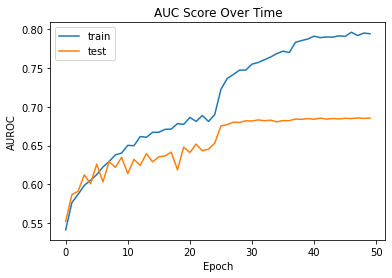

In [35]:
# TODO: Comparsion of CE/AUC
import matplotlib.pyplot as plt

plt.plot(train_list, label='train')
plt.plot(test_list, label='test')
plt.title('AUC Score Over Time')
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.legend()
plt.show()